In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint 
from scipy.integrate import solve_ivp
import random
import gillespie 
from scipy.interpolate import interp1d
import pdb

In [2]:
#epsilon parameters that can make the number of mutants increase
rho_min=0

rho=0.025
print(rho)

0.025


In [3]:
#mu=0.05
mu=0.07
#c=0.01
c=0.0025
delta=1
#K=100
K=60
sto_realisations=10
T=1200
gamma=0.05

In [4]:
h0=0.5
#on essaye d'éviter la division par 0 rho==0 and h0==1
if (delta==0 and h0==1): 
    w0=0
    m0=K
else:
    w0 = (1-h0)*K/(1-h0+delta*h0)
    m0 = h0*K/(1-h0+delta*h0)

# Initialisation de l'état initial
X = np.array([w0,m0,w0,m0]) ## on a deux unités 
print(X)

[30. 30. 30. 30.]


In [5]:
def rate_function(rates):
    return max(rates,0)  

In [6]:
V=np.array([[-1, 0, 0, 0, 1,0,0,0, -1,0,1,0], #w1
            [0, -1, 0, 0,0,1,0,0,0,-1,0,1],    #m1
            [0,0,-1,0,0,0,1,0,1,0,-1,0],       #w2
            [0,0,0,-1,0,0,0,1,0,1,0,-1]])     #m2
     

In [21]:
from tqdm import tqdm
# Simulation des populations
all_times = []
all_populations = []

for sim in tqdm(range(sto_realisations), desc="Simulations"):
    t = 0
    times_sim = [t]
    X = np.array([w0,m0,w0,m0])
    pop_sim = [X.copy()]
   

    while t <= T:
        # Calcul des taux
        a = np.array([rate_function((mu) * X[0]), #death W1
                      rate_function((mu)* X[1]),# death M1
                      rate_function((mu) * X[2]), #death W2
                      rate_function((mu)* X[3]), #death M2
                      rate_function((mu + c * (K - X[0] - X[1]))*X[0]), ##birth W1
                      rate_function((mu+ c * (K - X[0] - X[1]))*X[1]), ##birth M1
                      rate_function((mu+ c * (K - X[2] - X[3]))*X[2]), ##birth W2
                      rate_function((mu + c * (K - X[2] - X[3]))*X[3]), ##birth M2
                      rate_function((gamma)*X[0]), #change W1
                      rate_function((gamma)*X[1]), #change M1
                      rate_function((gamma)*X[2]), #change W2
                      rate_function((gamma)*X[3])]) #change M2
        
        
        # Somme des taux
        somme = np.sum(a)
        # Debug print
        #print(f'Simulation {sim}, t = {t:.4f}, X = {X}, a = {a}, rate_sum = {somme:.4f}')
        if somme==0:
            print('No more events possible, breaking out of the loop.')
            break 
            
         # Sélection de la réaction
        r1 = np.random.rand()
        r_compare= r1*somme
        
        cumulative_sum = np.cumsum(a)
        j = np.searchsorted(cumulative_sum, r_compare)
        # Debugging information
        #print(f'Random number ξ1: {r1}')
        #print(f'Threshold for reaction selection: {r_compare}')
        #print(f'Cumulative sums: {cumulative_sum}, Selected reaction: {j}')
        
           # Vérification que j est bien sélectionné parmi les réactions disponibles
        if j >= len(a):
            print(f'Error: j ({j}) is out of bounds for array a with length {len(a)}.')
            break
            
            
        X += V[:,j]
        
        
        # Calcul du temps d'événement
        r2 = np.random.rand()
        tau = np.log(1 / r2) / somme
        
        # Mettre à jour le temps
        t += tau
        if t > T:
            break
        times_sim.append(t)
        pop_sim.append(X.copy())
    
    # Enregistrer les résultats de la simulation
    all_times.append(times_sim)
    all_populations.append(pop_sim)

    

Simulations: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


In [22]:
total_time=1200
time_points = np.linspace(0, total_time, num=20)


# Calculer la fraction de mutants et l'ensemble moyen
h1_ensemble = np.zeros((len(time_points), sto_realisations))
m1_ensemble=np.zeros((len(time_points), sto_realisations))
w1_ensemble=np.zeros((len(time_points), sto_realisations))
h2_ensemble = np.zeros((len(time_points), sto_realisations))
m2_ensemble=np.zeros((len(time_points), sto_realisations))
w2_ensemble=np.zeros((len(time_points), sto_realisations))



for i in range(sto_realisations):
    times = all_times[i]
    populations = all_populations[i]
    
    for idx, t in enumerate(time_points):
        if t <= times[-1]:
            j = np.searchsorted(times, t)
            W1, M1, W2, M2 = populations[j] if j < len(populations) else populations[-1]
            h1_ensemble[idx, i] = M1 / (W1 + M1)
            m1_ensemble[idx,i]=M1
            w1_ensemble[idx,i]=W1
            
            h2_ensemble[idx, i] = M2 / (W2 + M2)
            m2_ensemble[idx,i]=M2
            w2_ensemble[idx,i]=W2
        else:
            h1_ensemble[idx, i] = h1_ensemble[idx - 1, i]
            m1_ensemble[idx, i] = m1_ensemble[idx - 1, i]
            w1_ensemble[idx, i] = w1_ensemble[idx - 1, i]
            
            
            h2_ensemble[idx, i] = h2_ensemble[idx - 1, i]
            m2_ensemble[idx, i] = m2_ensemble[idx - 1, i]
            w2_ensemble[idx, i] = w2_ensemble[idx - 1, i]

h1_mean = np.mean(h1_ensemble, axis=1)
m1_mean = np.mean(m1_ensemble, axis=1)
w1_mean = np.mean(w1_ensemble, axis=1)

h2_mean = np.mean(h2_ensemble, axis=1)
m2_mean = np.mean(m2_ensemble, axis=1)
w2_mean = np.mean(w2_ensemble, axis=1)

In [23]:
w1_std=np.std(w1_ensemble,axis=1)
#h_std #écart-type des moyennes des simulations 
w1_sem = w1_std/ np.sqrt(sto_realisations)

m1_std=np.std(m1_ensemble,axis=1)
m1_sem = m1_std/ np.sqrt(sto_realisations)
m1_sem #SEM pour chaque point de temps 
#estimation de l'incertitude de la moyenne des simulations à chaque instant dans le temps
w2_std=np.std(w2_ensemble,axis=1)
#h_std #écart-type des moyennes des simulations 
w2_sem = w2_std/ np.sqrt(sto_realisations)


m2_std=np.std(m2_ensemble,axis=1)
m2_sem = m2_std/ np.sqrt(sto_realisations)
m2_sem #SEM pour chaque point de temps 
#estimation de l'incertitude de la moyenne des simulations à chaque instant dans le temps

array([0.        , 3.37105325, 2.2192341 , 3.36392628, 3.18810288,
       4.40964851, 4.87862686, 5.24795198, 4.79176377, 5.3161076 ,
       6.37659784, 5.93877092, 6.02004983, 6.8571131 , 7.07255258,
       6.76756973, 7.75267696, 7.14849635, 7.84990446, 7.84990446])

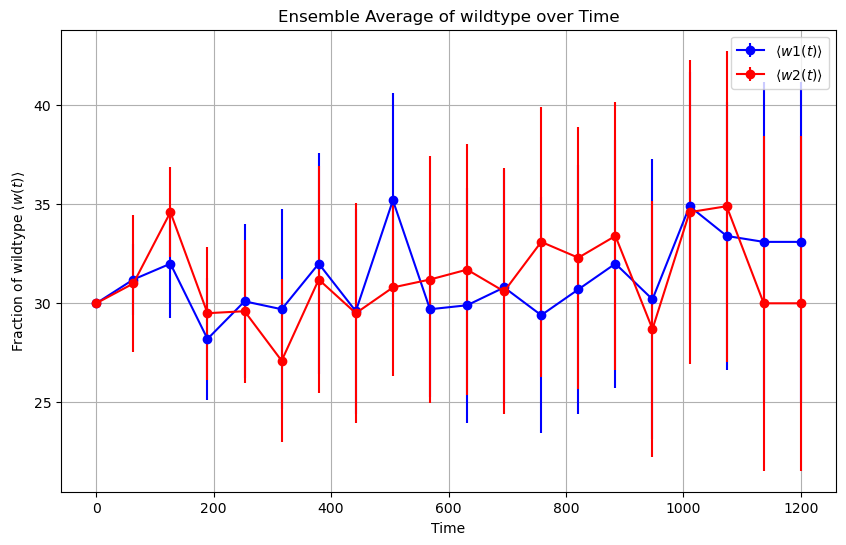

In [24]:
# Tracer les résultats avec des barres d'erreur
plt.figure(figsize=(10, 6))
plt.errorbar(time_points, w1_mean, yerr=w1_sem, fmt='b-', marker='o', label=r'$\langle w1(t) \rangle$')
plt.errorbar(time_points, w2_mean, yerr=w2_sem, fmt='r-', marker='o', label=r'$\langle w2(t) \rangle$')
plt.xlabel('Time')
plt.ylabel(r'Fraction of wildtype $\langle w(t) \rangle$')
plt.title('Ensemble Average of wildtype over Time')
plt.legend()
plt.grid(True)
plt.show()

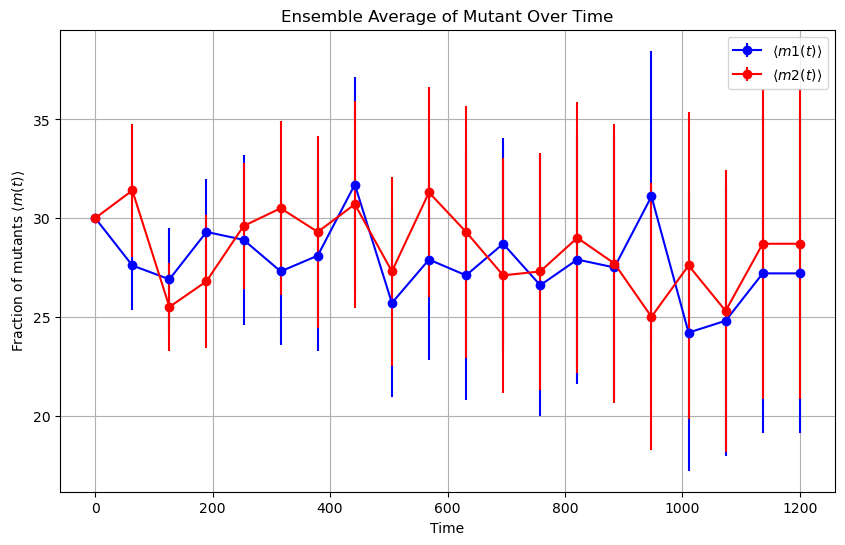

In [25]:
# Tracer les résultats avec des barres d'erreur
plt.figure(figsize=(10, 6))
plt.errorbar(time_points, m1_mean, yerr=m1_sem, fmt='b-', marker='o', label=r'$\langle m1(t) \rangle$')
plt.errorbar(time_points, m2_mean, yerr=m2_sem, fmt='r-', marker='o', label=r'$\langle m2(t) \rangle$')
plt.xlabel('Time')
plt.ylabel(r'Fraction of mutants $\langle m(t) \rangle$')
plt.title('Ensemble Average of Mutant Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
h1_std=np.std(h1_ensemble,axis=1)
#h_std #écart-type des moyennes des simulations 
h1_sem = h1_std/ np.sqrt(sto_realisations)
h1_sem #SEM pour chaque point de temps 
#estimation de l'incertitude de la moyenne des simulations à chaque instant dans le temps
h2_std=np.std(h2_ensemble,axis=1)
#h_std #écart-type des moyennes des simulations 
h2_sem = h2_std/ np.sqrt(sto_realisations)
h2_sem #SEM pour chaque point de temps 
#estimation de l'incertitude de la moyenne des simulations à chaque instant dans le temps


array([0.        , 0.04788768, 0.03332469, 0.05658287, 0.05546785,
       0.07257551, 0.08724915, 0.08709881, 0.07966155, 0.09302308,
       0.10399809, 0.10550504, 0.10531549, 0.10926828, 0.10971246,
       0.11920272, 0.12231541, 0.12583786, 0.13694549, 0.13694549])

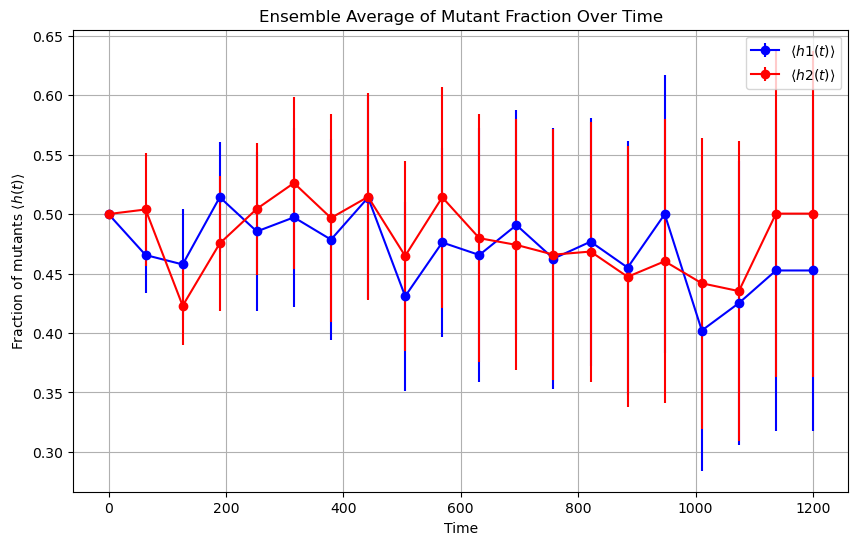

In [27]:
# Tracer les résultats avec des barres d'erreur
plt.figure(figsize=(10, 6))
plt.errorbar(time_points, h1_mean, yerr=h1_sem, fmt='b-', marker='o', label=r'$\langle h1(t) \rangle$')
plt.errorbar(time_points, h2_mean, yerr=h2_sem, fmt='r-', marker='o', label=r'$\langle h2(t) \rangle$')
plt.xlabel('Time')
plt.ylabel(r'Fraction of mutants $\langle h(t) \rangle$')
plt.title('Ensemble Average of Mutant Fraction Over Time')
plt.legend()
plt.grid(True)
plt.show()